# 9) Download CORS data according to Susana's presentation and compute iono gradients using dual frequency station pairwise.



Iono gradients are calculated with vertical iono range errors (I_vert with dual frequencies) and their Ionospheric pierce point at a single epoch. Using station pairs to calculate gradients.
<img src="ionograd.png">

Calculate gradient with some of the methods, depending on the grid of stations available:<br>
<ul><li>Requires stations apart less than 50Km</li>
<li>Is not affected by relative velocities of front and IPPs</li>
<li>IPP height is 350 Km</li></ul>


In [1]:
import numpy as np
import gpstk
from GNSS_TK1 import *
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline



###Iono Gradient ZOB1 and GARF
Iono slope [mm/Km] 20-22 Hour 72000-79200 11/20/2003

In [3]:
st1=["data/zob1324.03.n","data/zob13240.03o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,L,L,L,L=getdata_stationpair(st1,st2,"GPS 8")

In [4]:
print min(t1),max(t1)
print min(t2),max(t2)

18900.0 85020.0
20550.0 83430.0


In [5]:
print len(IPP1),len(t1),len(Icode1),len(Iphase1),len(VTECphase1),len(ELEV1)
print len(IPP2),len(t2),len(Icode2),len(Iphase2),len(VTECphase2),len(ELEV2)

963 963 963 963 963 963
745 745 745 745 745 745


###Observations between 20  22 hours (72000 and 79200 seconds)

In [6]:
tiempos1=get_obstimes(t1,72000,79200)
tiempos2=get_obstimes(t2,72000,79200)
print tiempos1[:10]
print tiempos2[:10]
print len(tiempos1),len(tiempos2)

[ 72000.  72030.  72060.  72090.  72120.  72150.  72180.  72210.  72240.
  72270.]
[ 72000.  72030.  72060.  72090.  72120.  72150.  72180.  72210.  72240.
  72270.]
239 241


In [7]:
tcommon=np.intersect1d(tiempos1,tiempos2)
print "Samples (every 30 segundos): ",np.size(tcommon)
print "First: ",np.min(tcommon),"Last: ",np.max(tcommon)

Samples (every 30 segundos):  239
First:  72000.0 Last:  79200.0


###First Results: Delay and Slant ZOB GARF

In [8]:
D=[]
gg=[]#gradient
#t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2
IC1,IC2,IPh1,IPh2,IPPs1,IPPs2=[],[],[],[],[],[]
t,EL1,EL2=[],[],[]
print  IPP1[tcommon[0]][0]


525959.002454


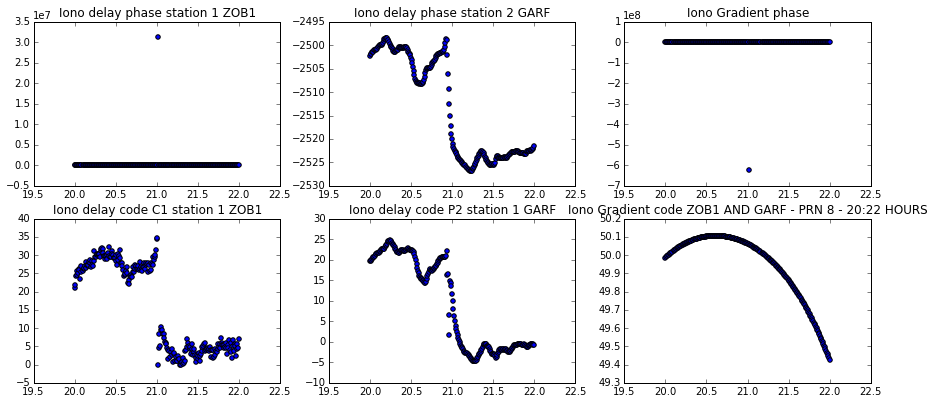

In [9]:
for time in tcommon:
    d=np.sqrt((IPP1[time][0]-IPP2[time][0])**2+(IPP1[time][1]-IPP2[time][1])**2+(IPP1[time][2]-IPP2[time][2])**2)
    D.append(d)
    EL1.append(ELEV1[time])
    EL2.append(ELEV2[time])
    IC1.append(Icode1[time])
    IC2.append(Icode2[time])
    IPh1.append(Iphase1[time])
    IPh2.append(Iphase2[time])
    t.append(time)

D=np.array(D)/1000
t=np.array(t)/3600 
IC1=np.array(IC1)
IC2=np.array(IC2)
IP1=np.array(IPh1)
IP2=np.array(IPh2)
EL1=np.array(EL1)
EL2=np.array(EL2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1 ZOB1")
plt.scatter(t,IP1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2 GARF")
plt.scatter(t,IP2)
plt.subplot(3,3,3)
plt.title("Iono Gradient phase")
DelayP=((IP2-IP1)*1000)/D #Km/mm
plt.scatter(t,DelayP)
plt.subplot(3,3,4)
plt.title("Iono delay code C1 station 1 ZOB1")
plt.scatter(t,IC1)
plt.subplot(3,3,5)
plt.title("Iono delay code P2 station 1 GARF")
plt.scatter(t,IC2)
plt.subplot(3,3,6)
plt.title("Iono Gradient code ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
DelayC=((IC1-IC2)*1000)/D
plt.scatter(t,D)

#Preprocessing

We can see that there are huge ambiguities on phase measurements and the ones made with the C1 and P2 codes are too noisy. **First we have to make some preprocessing.** <br>From Lee's paper "We first perform pre-processing on the code-
derived, <i>I code</i>, and carrier-derived, <i>I phase </i> , observables, which includes cycle slip detection and correction, short arc removal, outlier removal, and code-carrier smoothing."<br>


#IOD Cycle Slips

**Data jump indicator:** the difference between two adjacent ionospheric delays, ∇Iφ , is examined to detect a
data jump greater than the slip detection threshold of 0.5 m for a nominal day

In [10]:
jumps1=datajump(IP1,t,2.5) #tgap1
print "Data jumps in slant delay station1 : ",jumps1

jumps2=datajump(IP2,t,2.5) #tgap1
print "Data jumps in  in slant delay station2: ",jumps2

Data jumps in slant delay station1 :  [121 123]
Data jumps in  in slant delay station2:  []


**Confirm that  ∇Iφ takes big jumps:** 

In [11]:
print IP1[120],IP1[121],IP1[122],IP1[123],IP1[124]

-7.10544863667 31196393.6747 15.6153216932 26.5055548433 24.3405847596


##Continuous arcs are divided into "several" subarcs
Using de datajumps we split our arc into miniarcs

In [12]:
def sub_arcs(lI,jumps): #returns intervals of each sub-arc inside
    miniarcs=np.split(range(lI.size),jumps)
    return miniarcs

In [13]:
miniarcs1=sub_arcs(IP1,jumps1)
print "Total subarcs=",len(miniarcs1)
for i in range(len(miniarcs1)):
    print "Arc ",i," has ",len(miniarcs1[i])," elements"

Total subarcs= 3
Arc  0  has  121  elements
Arc  1  has  2  elements
Arc  2  has  116  elements


In [14]:
miniarcs2=sub_arcs(IP2,jumps2)
print "Total subarcs=",len(miniarcs2)
for i in range(len(miniarcs2)):
    print "Arc ",i," has ",len(miniarcs2[i])," elements" 

Total subarcs= 1
Arc  0  has  239  elements


In [15]:
print miniarcs1[0].size
print miniarcs1[1].size
print miniarcs1[2].size

121
2
116


##Short arc Removal
Also, miniarcs with less than 10 elements, or five minutes are removed. **The short arcs need to be discarded because leveling errors for those arcs are typically large and cause ionospheric delay estimation errors. **

In [16]:
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)
miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2) #que borre los subarcos de una en la otra estacion?

239 239 239 239 239 239
SubArc #  0
SubArc #  1
Sub-Arcs deleted 1 [121 122]
SubArc #  2

Deleted elements on the other station:  {0: [121, 122]}

New # of subarcs arc1:  2

New # of subarcs of arc2 (other station):  1


In [17]:
print len(IP1),len(IC1),len(IP2),len(IC2),len(t),len(D)

239 239 239 239 239 239


In [18]:
miniarcs2

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179

In [19]:
IP1[miniarcs1[1]]
print len(miniarcs1[0]),len(miniarcs1[1]),len(IP1)

121 116 239


##Polinomial fit & Outlier detection and Removal
In this step a polinomyal fit and outlier factor methods are executed on each sub arc. **If the biggest slip for both methods is the same the outlier is confirmed and removed.**

###Polinomial fit

A polynomial fit is performed on the carrier-derived observables, Iphase , and the differential residuals of the fit are computed. If the largest jump between adjacent points exceeds an outlier (or slip) detection parameter of **0.8 meters? or 2.5,** the jump is classified as a potential outlier. 


Biggest Slip detected with polinomyal fit:  None
Biggest Slip detected with polinomyal fit:  None


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


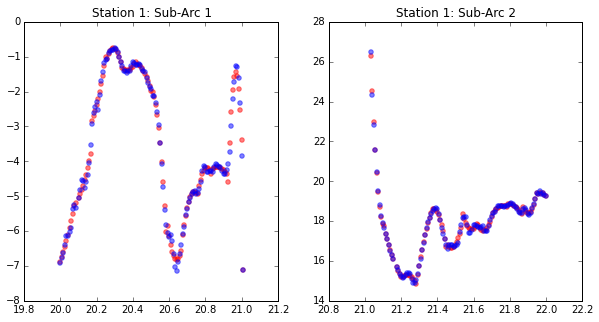

In [20]:
plt.figure(figsize=(10,5))
P11,pslip11=poly_fit(IP1[miniarcs1[0]],t[miniarcs1[0]])
plt.subplot(1,2,1)
plt.title("Station 1: Sub-Arc 1")
plt.scatter(t[miniarcs1[0]],P11,color="red",alpha=.5)
plt.scatter(t[miniarcs1[0]],IP1[miniarcs1[0]],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip11#,t[miniarcs1[0]][pslip11] 

P12,pslip12=poly_fit(IP1[miniarcs1[1]],t[miniarcs1[1]])
plt.subplot(1,2,2)
plt.title("Station 1: Sub-Arc 2")
plt.scatter(t[miniarcs1[1]],P12,color="red",alpha=.5)
plt.scatter(t[miniarcs1[1]],IP1[miniarcs1[1]],color="blue",alpha=.5)
print "Biggest Slip detected with polinomyal fit: ",pslip12#,t[miniarcs1[1]][pslip12]

111
Biggest Slip detected with polinomyal fit:  111 20.9333333333


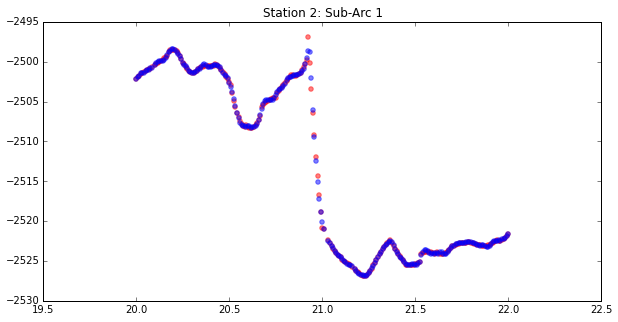

In [21]:
plt.figure(figsize=(10,5)) #this isn's divided 
P2,pslip2=poly_fit(IP2[miniarcs2[0]],t[miniarcs2[0]])
plt.title("Station 2: Sub-Arc 1")
plt.scatter(t[miniarcs2[0]],P2,color="red",alpha=.5)
plt.scatter(t[miniarcs2[0]],IP2[miniarcs2[0]],color="blue",alpha=.5)
print pslip2
print "Biggest Slip detected with polinomyal fit: ",pslip2,t[miniarcs2[0]][pslip2] 

###Outlier Factor<br>
**Algorithm takes n inputs
x, f(x), k (neighbours) --->OF with the outlier factor for every f(x) and Z (set of outliers, size "m", m < n)** <br>
k=10, neighbours close are observations  close for 5 minutes to the epoch
Second, the difference of I between adjacent points is
computed using the adjacent point difference algorithm in
[16]. The averaged difference (i.e., Outlier Factor (OF)),
between adjacent points of point p at time t p is calculated


In [22]:
outliers11,oslip11=outlier_detect(IP1[miniarcs1[0]],t[miniarcs1[0]]*3600)
print "Elements in OFt: ",outliers11.size
print "Biggest slip detected in: ",oslip11
print IP1[miniarcs1[0]][oslip11]
print t[miniarcs1[0]][oslip11]

Elements in OFt:  121
Biggest slip detected in:  8
-5.36371579545
20.0666666667


In [23]:
outliers12,oslip12=outlier_detect(IP1[miniarcs1[1]],t[miniarcs1[1]]*3600)
print "Elements in OFt: ",outliers12.size
print "Biggest slip detected in: ",oslip12
print IP1[miniarcs1[1]][oslip12]
print t[miniarcs1[1]][oslip12]

Elements in OFt:  116
Biggest slip detected in:  0
26.5055548433
21.0333333333


In [24]:
outliers2,oslip2=outlier_detect(IP2[miniarcs2[0]],t[miniarcs2[0]]*3600)
print "Elements in OFt: ",outliers2.size
print "Biggest slip detected in: ",oslip2
print IP2[miniarcs2[0]][oslip2]
print t[miniarcs2[0]][oslip2]

Elements in OFt:  237
Biggest slip detected in:  121
-2522.47719051
21.0333333333


#Removing outliers

In [25]:
outliers11=confirmed_slip(IP1[miniarcs1[0]],t[miniarcs1[0]],threshold=0.8)
print outliers11
outliers12=confirmed_slip(IP1[miniarcs1[1]],t[miniarcs1[1]],threshold=0.8)
print outliers12
outliers2=confirmed_slip(IP2[miniarcs2[0]],t[miniarcs2[0]],threshold=0.8)
print outliers2

[]
[]
[]


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [26]:
print len(miniarcs1[0])
print len(miniarcs1[1])
print len(miniarcs2[0])

121
116
237


#Leveling phase using code: Removes ambiguity

In [27]:
Lfactor11,new_IPHASE_arc11=levelphase(IC1[miniarcs1[0]],IP1[miniarcs1[0]],EL1[miniarcs1[0]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor11,new_IPHASE_arc11.size

print len(t[miniarcs1[0]])
print len(IC1[miniarcs1[0]]),len(IP1[miniarcs1[0]]),len(EL1[miniarcs1[0]])

Leveling factor:  31.1359272574 121
121
121 121 121


In [28]:
Lfactor12,new_IPHASE_arc12=levelphase(IC1[miniarcs1[1]],IP1[miniarcs1[1]],EL1[miniarcs1[1]]) #corregido manualmente tomando el tercer arco
print "Leveling factor: ",Lfactor12,new_IPHASE_arc12.size

Leveling factor:  -13.9594366215 116


In [29]:
#Station 2
Lfactor2,new_IPHASE_arc2=levelphase(IC2[miniarcs2[0]],IP2[miniarcs2[0]],EL2[miniarcs2[0]]) #IC1 code delay on station1
print "Leveling factor: ",Lfactor2,new_IPHASE_arc2.size


Leveling factor:  2522.80026239 237


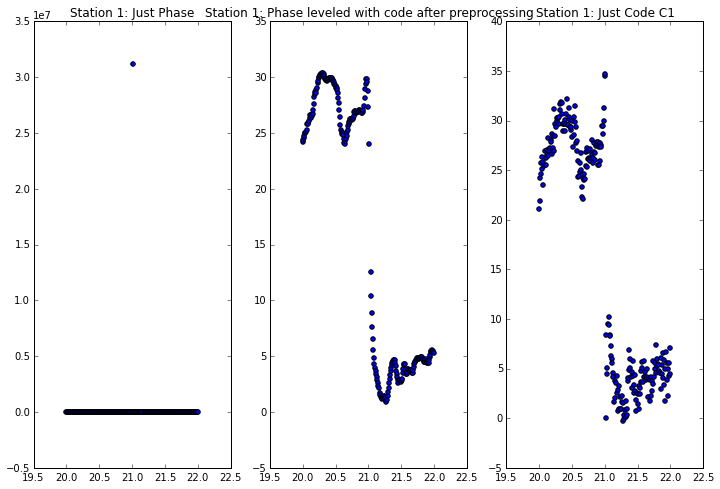

In [30]:
#for some reason usin elevation as a weight doesn't fix the ambiguity
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 1: Just Phase")
plt.scatter(t,IP1)

plt.subplot(1,3,2)
plt.title("Station 1: Phase leveled with code after preprocessing")
plt.scatter(t[miniarcs1[0]],new_IPHASE_arc11)
plt.scatter(t[miniarcs1[1]],new_IPHASE_arc12)

plt.subplot(1,3,3)
plt.title("Station 1: Just Code C1")
plt.scatter(t,IC1)

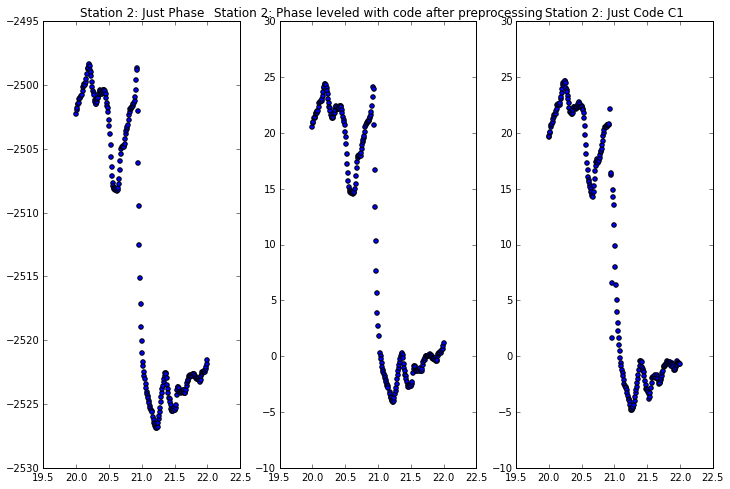

In [31]:
#for some reason usin elevation as a weight doesn't fix the ambiguity
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.title("Station 2: Just Phase")
plt.scatter(t,IP2)

plt.subplot(1,3,2)
plt.title("Station 2: Phase leveled with code after preprocessing")
plt.scatter(t[miniarcs2[0]],new_IPHASE_arc2)

plt.subplot(1,3,3)
plt.title("Station 2: Just Code C1")
plt.scatter(t,IC2)

#FINALLY GRADIENT!

In [32]:
ntimes2=t[miniarcs2[0]]
ntimes1=np.hstack((t[miniarcs1[0]],t[miniarcs1[1]])) #podría ese punto hacer falta y dañar el grad
new_IPHASE_arc1=np.hstack((new_IPHASE_arc11,new_IPHASE_arc12 ))

D=np.hstack((D[miniarcs1[0]],D[miniarcs1[1]])) #o [miniarcs2[0]]
print ntimes1.size,new_IPHASE_arc1.size
print ntimes2.size,new_IPHASE_arc2.size

237 237
237 237


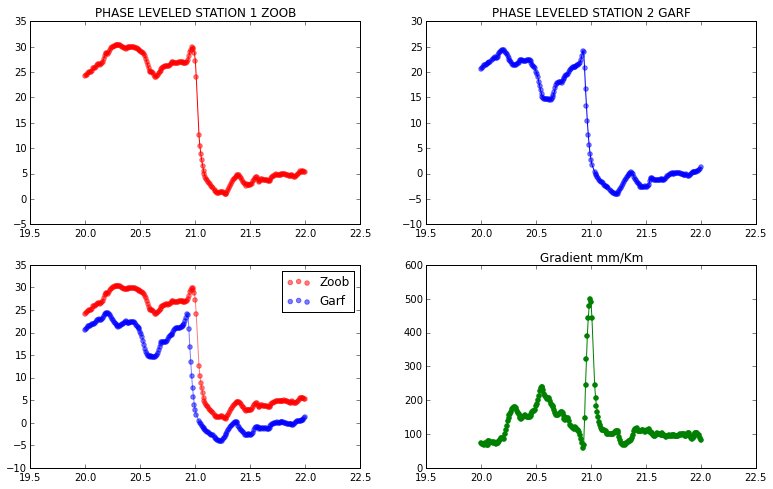

In [33]:
plt.figure(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("PHASE LEVELED STATION 1 ZOOB")
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.plot(ntimes1,new_IPHASE_arc1,color="red")
plt.subplot(2,2,2)
plt.title("PHASE LEVELED STATION 2 GARF")
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.plot(ntimes2,new_IPHASE_arc2,color="blue")
plt.subplot(2,2,3)
plt.scatter(ntimes1,new_IPHASE_arc1,color="red",alpha=.5,marker='o', label="Zoob")
plt.plot(ntimes1,new_IPHASE_arc1,color="red",alpha=.5)
plt.scatter(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5,label="Garf")
plt.plot(ntimes2,new_IPHASE_arc2,color="blue",alpha=.5)
plt.legend()
##aELIMINAR TAMBIEN EL SHORT ARC EN LA OTRA ESTACION Y EN LA DISTANCIA ENTRE IPPS
gradient=(new_IPHASE_arc1-new_IPHASE_arc2)*1000 
plt.subplot(2,2,4)
plt.title("Gradient mm/Km")
plt.scatter(ntimes1,gradient/D,color="green")
plt.plot(ntimes1,gradient/D,color="green")
